In [1]:
from janus_wraper import *
import torch
from transformers import AutoModelForCausalLM
from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
from Janus.janus.utils.io import load_pil_images

# specify the path to the model
model_path = "/projectnb/cs598/projects/cool_proj/model"
device = 'cuda'

chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)

gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
gpt = gpt.to(torch.bfloat16).to(device).eval()





Python version is above 3.10, patching the collections module.


/projectnb/cs598/projects/cool_proj/.venv/lib/python3.11/site-packages/transformers/models/auto/image_processing_auto.py:592: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Python version is above 3.10, patching the collections module.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: mask_prompt, sft_format, num_image_tokens, 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

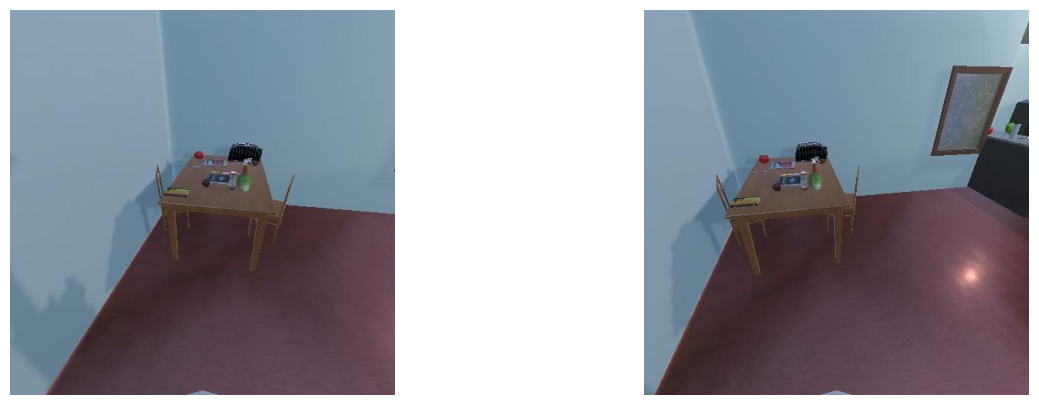

The first image is from the beginning of the video and the second image is from the end. How did the camera likely move when shooting the video?
['rotated right' 'rotated left']
rotated right


In [2]:
import pandas as pd
import io
from PIL import Image

df = pd.read_parquet('/projectnb/cs598/projects/cool_proj/dataset', engine='pyarrow')#change path here

example = df.iloc[10]
images = [Image.open(io.BytesIO(im_bytes)) for im_bytes in example['image_bytes']]

import matplotlib.pyplot as plt

# Display images
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

if len(images) == 1:
    axes.imshow(images[0])
    axes.axis("off")
else:
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")

plt.show()

question = example['question']
print(question)
answer_choices = example['answers']
print(answer_choices)
correct_answer = example['correct_answer']
print(correct_answer)

# Function to convert bytes to BytesIO objects
def convert_to_bytesio(image_bytes):
    return np.asarray([Image.open(io.BytesIO(im_bytes)) for im_bytes in image_bytes][0], dtype=np.uint8)

    # if isinstance(image_bytes, ):
    #     # If it's a list of images, convert each image
    #     return [Image.open(io.BytesIO(im_bytes)) for im_bytes in image_bytes]
    # else:
    #     print(type(image_bytes))
    #     # If it's a single image
    #     return Image.open(io.BytesIO(image_bytes))


# Apply the conversion to the entire column
df['image_bytes'] = df['image_bytes'].apply(convert_to_bytesio)


In [7]:
from tqdm import tqdm
import re
def extract_ans(pred_text):
    matches = re.findall(r"\[(.*?)\]", pred_text)
    
    return matches

def predict_all(dataset, vl_chat_processor, vl_gpt, device='cuda'):
    predictions = []
    n_correct = 0
    for i in (pbar := tqdm(range(len(dataset['image_bytes'])))):
        input_image = dataset['image_bytes'][i]
        question = dataset['question'][i]
        answer_choices = dataset['answers'][i]
        
        input_prompt = f'''
                        Instructions: You have to answer the following question using the given options.
                                      Enclose your answer in [].
                                      For example, if the answer is yes, it must be formatted like [yes].

                        Question: {question}

                        Image: {input_image}
                        Your answer must contain just the options given below. Enclose the answer in brackets like [answer].
                        Options: {answer_choices}                        
                
                       '''

        prediction_text = janus_pro_generate(
            vl_chat_processor=vl_chat_processor,
            vl_gpt=vl_gpt,
            input_text=input_prompt,
            # answer_choices=answer_choices,
            input_image=input_image,
            device=device,
            output_mode="text",
            temperature=0.1,
            top_p=0.95,
            seed=42
        )
        prediction = extract_ans(prediction_text)
        predictions.append({
            "question": question,
            "answers": answer_choices,
            "pred_text": prediction_text,
            "prediction": prediction,
            "correct_answer": dataset['correct_answer'][i]
        })
        
        try:
            if len(prediction) == 1:
                if prediction[0] == dataset['correct_answer'][i]:
                    n_correct += 1
            else:
                
        except:
            pass
            
        pbar.set_description(f'{n_correct} correct')
        # print(f"Question: {question}")
        # print(f"Choices: {answer_choices}")
        # print(f"Predicted Answer: {prediction}")
        # print(f"Correct Answer: {dataset['correct_answer'][i]}")
        # print("-" * 50)

    return predictions

predictions = predict_all(df, chat_processor, gpt)
#made a prediction function but might need some fixing @Surya

2166 correct: 100%|██████████| 4001/4001 [41:59<00:00,  1.59it/s] 


In [5]:
import json
for entry in predictions:
    for key, value in entry.items():
        if isinstance(value, np.ndarray):
            entry[key] = value.tolist()  # Convert ndarray to list

# Save to file
with open("predictions_thinkTokens.txt", "w", encoding="utf-8") as f:
    json.dump(predictions, f, indent=4, ensure_ascii=False)

print("Predictions saved to predictions.txt")

Predictions saved to predictions.txt
